In [5]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import astropy.units as u
from scipy.ndimage import gaussian_filter
import fkplotlib

<IPython.core.display.Javascript object>


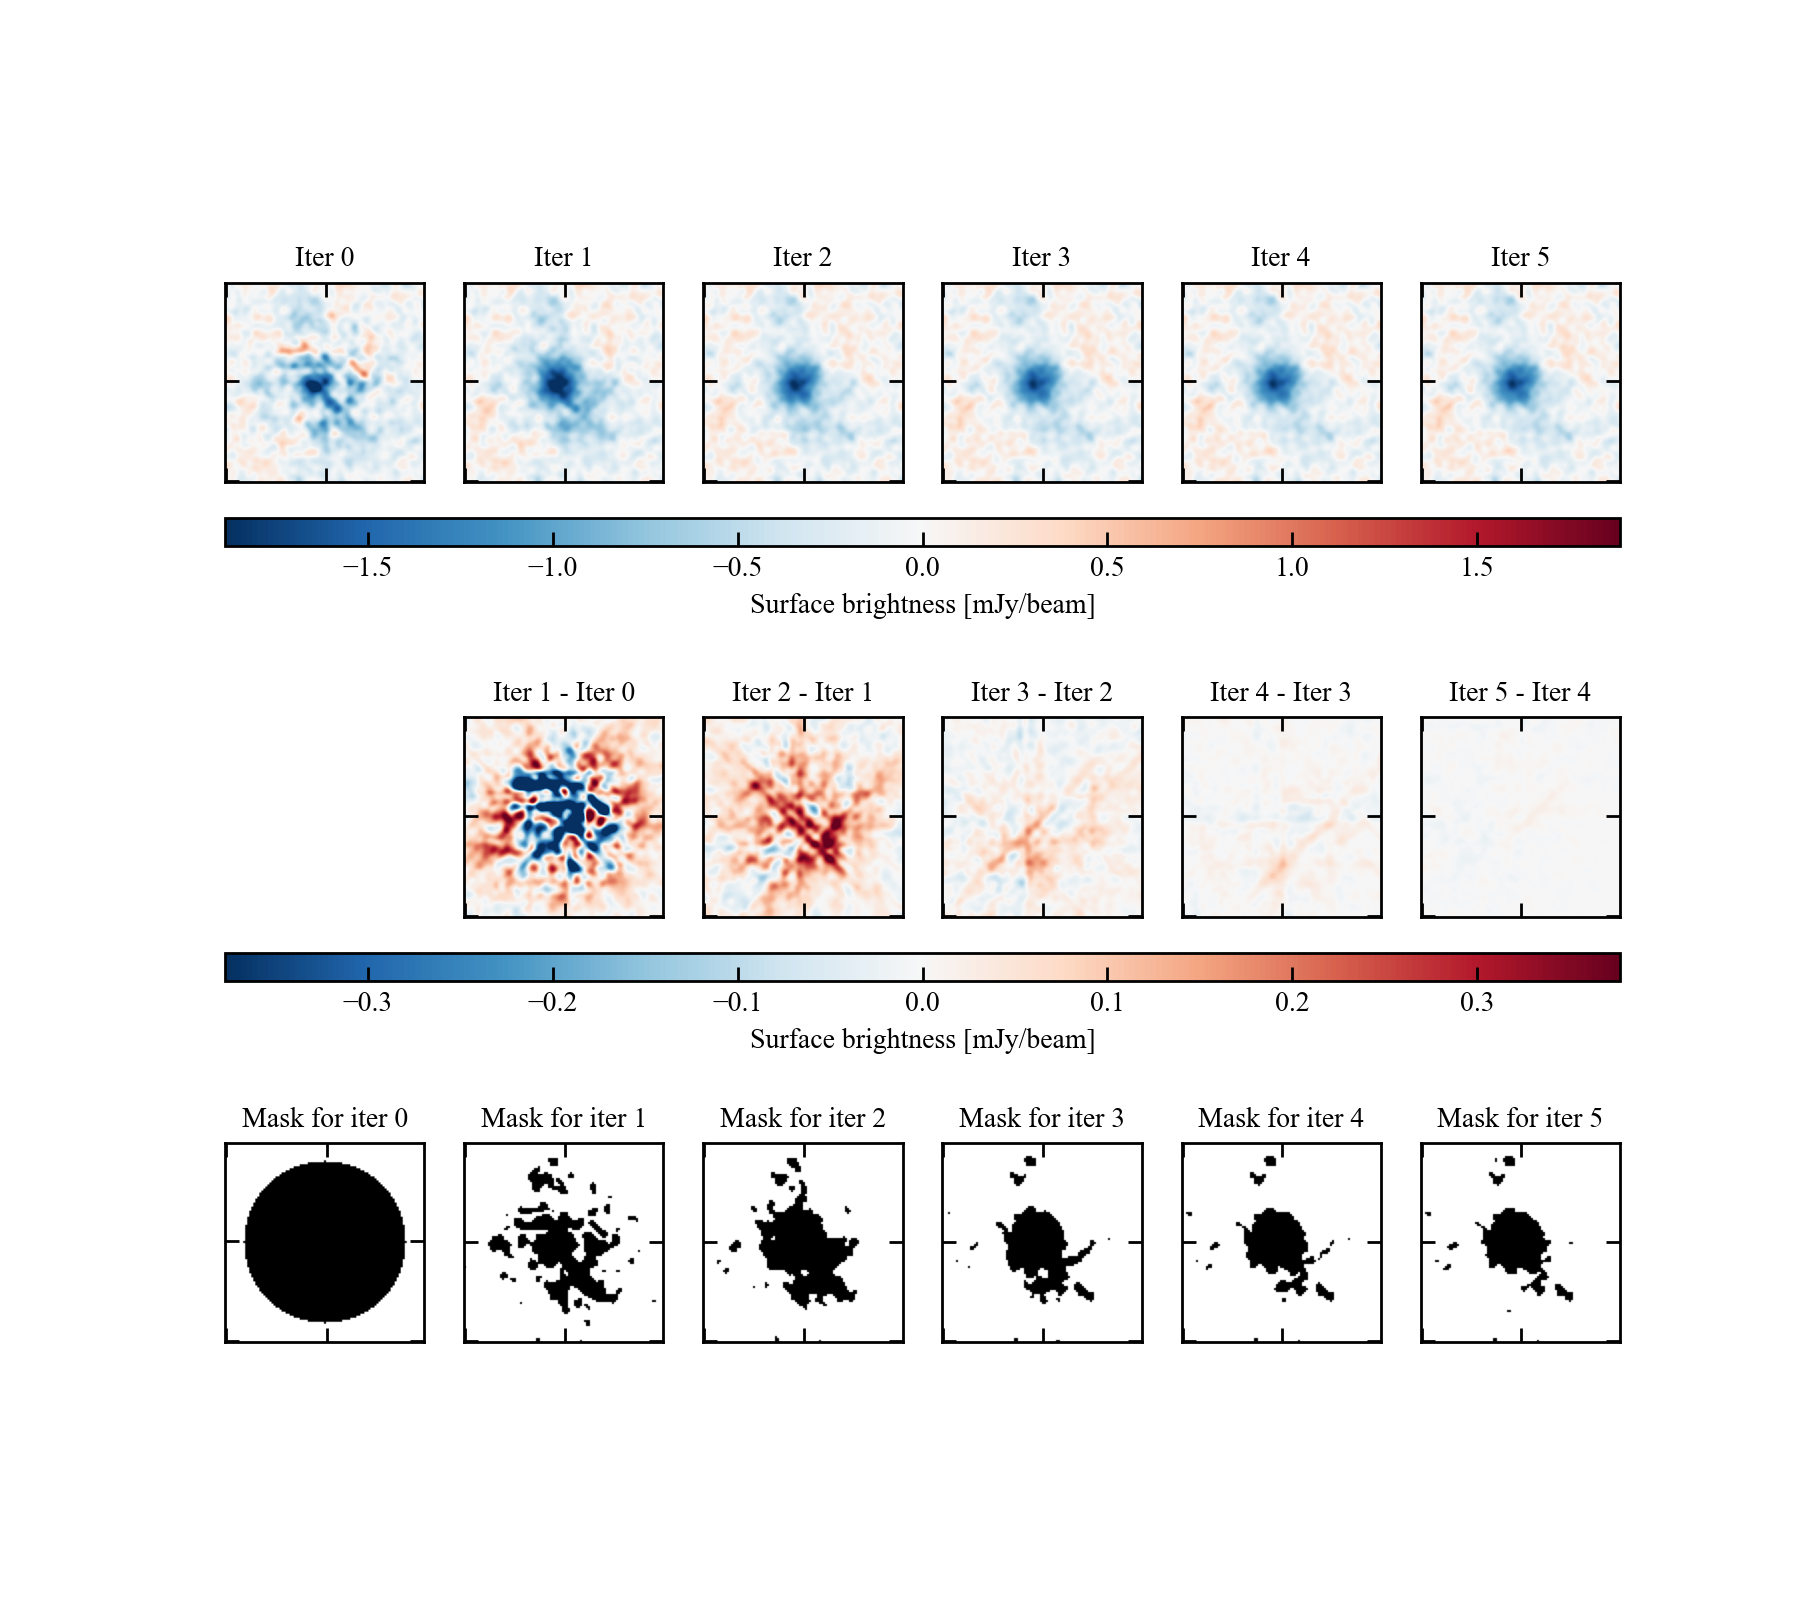

In [88]:
plt.close('all')

crop = 5.0 * u.arcmin
path = "./Data/PSZ2G183/"
niter = 6
cmap = "RdBu_r"

with fits.open(path + "/iter" + str(niter - 1) + "/map.fits") as hdulist:
    head = hdulist[4].header
    pix_size = (np.abs(head["CDELT1"]) * u.deg).to("arcsec")
    smooth_sigma = (10.0 * u.arcsec * 0.4247 / pix_size).value # smooth with a 10" FWHM gaussian

    wcs = WCS(head)
    npix_0 = hdulist[4].data.shape[0]
    data = Cutout2D(
        1e3 * hdulist[4].data,
        SkyCoord(head["CRVAL1"] * u.deg, head["CRVAL2"] * u.deg),
        crop,
        wcs=wcs,
    )
    data_smooth = gaussian_filter(data.data, smooth_sigma)
    npix = data.shape[0]
    bbox = np.array(data.bbox_original)
    vmin = np.min(data_smooth)


fig, axs = plt.subplots(3, niter, figsize=(1.8 * (niter - 1), 8))

for i in range(niter):
    ax1 = axs[0, i]
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_title("Iter " + str(i), fontsize=10)

    data = 1e3 * fits.getdata(path + "/iter" + str(i) + "/map.fits", 4)
    data = data[bbox[0, 0] : bbox[0, 1] + 1, bbox[1, 0] : bbox[1, 1] + 1]
    data_smooth = gaussian_filter(data, smooth_sigma)

    im1 = ax1.imshow(
        data_smooth,
        vmin=vmin,
        vmax=-vmin,
        origin="lower",
        cmap=cmap,
        interpolation="gaussian",
    )

    if i != 0:
        ax2 = axs[1, i]
        ax2.set_title("Iter " + str(i) + " - " + "Iter " + str(i - 1), fontsize=10)
        data2 = 1e3 * fits.getdata(path + "/iter" + str(i - 1) + "/map.fits", 4)
        data2 = data2[bbox[0, 0] : bbox[0, 1] + 1, bbox[1, 0] : bbox[1, 1] + 1]
        data2_smooth = gaussian_filter(data2, smooth_sigma)

        diff = data_smooth - data2_smooth

        im2 = ax2.imshow(
            diff,
            vmin=vmin / 5,
            vmax=-vmin / 5,
            origin="lower",
            cmap=cmap,
            interpolation="gaussian",
        )
    
    axs[2, i].set_title("Mask for iter " + str(i), fontsize=10)
    if i != niter-1:
        ax3 = axs[2, i+1]
        noise = 1e3 * fits.getdata(path + "/iter" + str(i) + "/map.fits", 5)
        noise = noise[bbox[0, 0] : bbox[0, 1] + 1, bbox[1, 0] : bbox[1, 1] + 1]
        noise_smooth = gaussian_filter(noise, smooth_sigma) / np.sqrt(2*np.pi*smooth_sigma**2)
        snr = data_smooth / noise_smooth
        msk = np.abs(snr) >= 3.0
        ax3.imshow(msk.astype(float), cmap="binary", vmin=0.0, vmax=1.0, origin="lower")

# mask for 0th iteration
rmap = 3.0 * np.hypot(*np.meshgrid(1 + np.arange(-(npix-1)//2, (npix-1)//2), 1 + np.arange(-(npix-1)//2, (npix-1)//2)))
msk = rmap <= 120.0
axs[2, 0].imshow(msk.astype(float), cmap="binary", vmin=0.0, vmax=1.0, origin="lower")

for ax in axs.flatten():
    fkplotlib.ax_bothticks(ax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
axs[1, 0].set_visible(False)

cbs = [
    fig.colorbar(im1, ax=axs[0, :], orientation="horizontal", pad=0.1, aspect=50, fraction=0.1), 
    fig.colorbar(im2, ax=axs[1, :], orientation="horizontal", pad=0.1, aspect=50, fraction=0.1)
]
for cb in cbs:
    cb.set_label("Surface brightness [mJy/beam]")
fig.savefig("PSZ2G183_evol_iters.pdf")

In [59]:
npix
rmap = 3.0 * np.hypot(*np.meshgrid(1 + np.arange(-(npix-1)//2, (npix-1)//2), 1 + np.arange(-(npix-1)//2, (npix-1)//2)))
msk = rmap <= 120.0

array([[69.29646456, 68.59300256, 67.89698079, ..., 67.89698079,
        68.59300256, 69.29646456],
       [68.59300256, 67.88225099, 67.17886572, ..., 67.17886572,
        67.88225099, 68.59300256],
       [67.89698079, 67.17886572, 66.46803743, ..., 66.46803743,
        67.17886572, 67.89698079],
       ...,
       [67.89698079, 67.17886572, 66.46803743, ..., 66.46803743,
        67.17886572, 67.89698079],
       [68.59300256, 67.88225099, 67.17886572, ..., 67.17886572,
        67.88225099, 68.59300256],
       [69.29646456, 68.59300256, 67.89698079, ..., 67.89698079,
        68.59300256, 69.29646456]])